In [2]:

import numpy as np
%matplotlib notebook
import matplotlib.pyplot as plt
import matplotlib.colors as colors
from scipy.constants import c,hbar,k

import sys

sys.path.append('../scripts')

%load_ext autoreload
%autoreload 2

from elements import *

import measurement as me

## Define parameters of the optomechanical system

In [10]:
#Inputs

lambda_c=850e-9
finesse=1e4
cavity_length=250e-6
f_m=2.5e6
Q=3e7
eta_c=0.7 #fraction of losses due to transmission through output mirror, out-coupling efficiency
eta_in=0.1 #fraction of losses due to transmission through input mirror 
#(These last two parameters are inferred from Dal's coating calculations)
t=30e-9 #membrane thickness
n_index=2 #membrane refractive index
m_eff=2e-12

#Derived quantities

omega_c=2*np.pi*c/lambda_c
omega_m=2*np.pi*f_m
omega_fsr=np.pi*c/cavity_length
kappa=omega_fsr/finesse
kappa_ex=kappa*eta_c
kappa_in=kappa*eta_in
kappa_0=kappa-kappa_ex-kappa_in
gamma=2*np.pi*f_m/Q

delta=omega_c*t*n_index/c  #phase shift for membrane transmission
r_int=abs((n_index-1)/(n_index+1)) #interface reflection coefficient
F_mbr=(2*r_int/(1-r_int**2))**2
reflectivity=np.sqrt(F_mbr*(np.sin(delta))**2./(1+F_mbr*np.sin(delta)**2)) #membrane reflection coefficient
G_pull=2*reflectivity*omega_c/cavity_length #frequency-pull factor (maximal value)

x_zp=np.sqrt(hbar/2/m_eff/(2*np.pi*f_m)) #Zero-point displacement of the mechanical oscillator
g0=G_pull*x_zp
n_th=k*300/hbar/omega_m

print (f'Vacuum coupling rate: {g0/2/np.pi:.0f} Hz')
print(f'Number of phonons at room temperature: {n_th*1e-6:.2f} millions')
print(f'Input power for QBA comparable to thermal noise: {1e6*hbar*omega_c*kappa*n_th/(4*eta_in*(4*g0**2/kappa/gamma)):.2f} uW')
print(f'Decoherence rate of the oscillator at room temperature: {1e-3*n_th*gamma/2/np.pi:.0f} kHz')
print(f'Vacuum cooperativity: {4*g0**2/kappa/gamma:.2f}')

Vacuum coupling rate: 1120 Hz
Number of phonons at room temperature: 543308473690688514424832.00 millions
Input power for QBA comparable to thermal noise: 119104331067743618453209088.00 uW
Decoherence rate of the oscillator at room temperature: 45275706140890719556993024 kHz
Vacuum cooperativity: 1.00


## Estimation of $\bar{n}_c$ and $g$

14998369.92853055


<IPython.core.display.Javascript object>


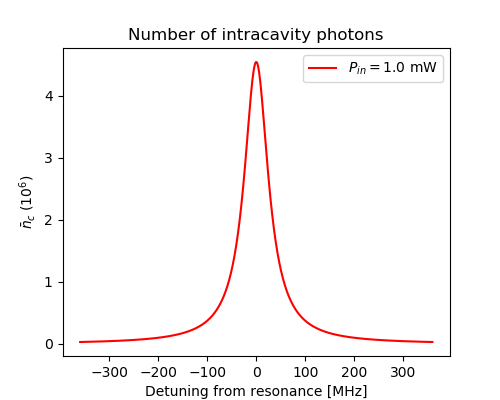

Cooperativity: 4561618
Relative to thermal phonon number: 1.824
Output power: 280 uW


In [6]:
#The laser is assumed locked to cavity resonance

def ic_photon_number(eta_in,kappa,P_in,omega_drive,det):
    n_c=4*eta_in*P_in/kappa/hbar/omega_drive/(1+(2*det/kappa)**2)
    return n_c

P_in=1e-3
omega_drive=omega_c
n_c=ic_photon_number(eta_in,kappa,P_in,omega_drive,2*np.pi*0)
g=g0*np.sqrt(n_c)
Cooperativity=4*g**2/kappa/gamma
P_out=hbar*omega_drive*kappa_ex*n_c
print(g)
#plt.figure()
plt.figure(figsize=(5,4))
det=np.linspace(-6*kappa,6*kappa,1001)
n_sweep=np.empty(len(det))
k=0
for d in det:
    n_sweep[k]=ic_photon_number(eta_in,kappa,P_in,omega_drive,d)
    k+=1
plt.plot(1e-6*det/2/np.pi,n_sweep*1e-6,c='r',label='$P_{in}=$' + str(P_in*1e3) + ' mW')
plt.xlabel('Detuning from resonance [MHz]')
plt.ylabel(r'$\bar{n}_c\;(10^6)$')
plt.title('Number of intracavity photons')
plt.gca().legend(loc='upper right');
plt.show()

print(f'Cooperativity: {Cooperativity:.0f}')
print(f'Relative to thermal phonon number: {Cooperativity/n_th:.3f}')
print(f'Output power: {P_out*1e6:.0f} uW')

## System definition (modes, inputs and coupling)

In [7]:
a = Mode('a', omega_c)
b = Mode('b', omega_m)

a_in0 = Input('0', a, kappa_0, kind='bath', bath_temp=300)
a_in1 = Input('ex', a, kappa_in, kind = 'drive', omega_drive = omega_drive, bath_temp=300) #Input tone
a_in2 = Input('0', a, kappa_ex, kind='bath', bath_temp=300)
b_in0 = Input('0', b, gamma, kind = 'bath', bath_temp=300)

g_ab = Coupling(a, b, g * np.array([1,0,0,0]))

sys_om = System([a, b], [a_in0, a_in1, a_in2, b_in0], [g_ab])

## Definition of output and homodyne spectrum calculation

<IPython.core.display.Javascript object>


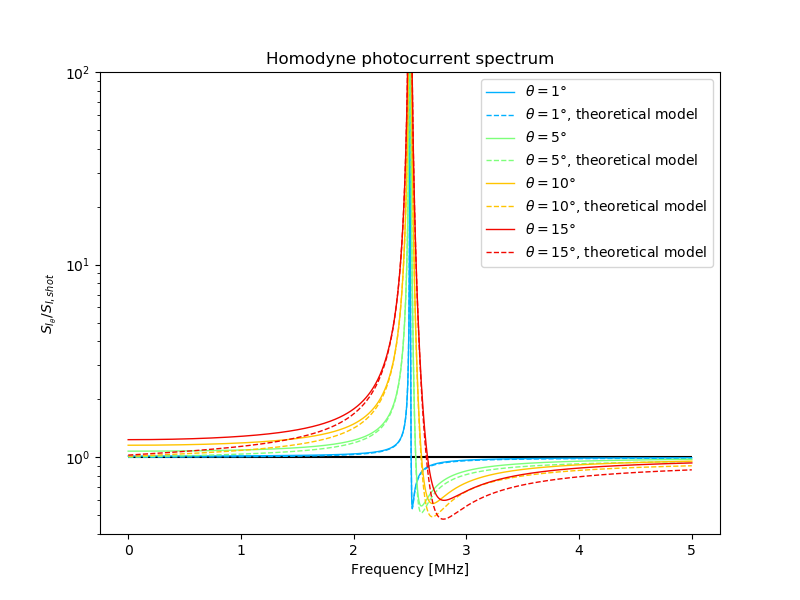

In [9]:
a_out2 = Output(sys_om,a_in2)
plot_bw=5e6 #Frequency window on which spectra are calculated
omegas = np.linspace(omega_m-2*np.pi*plot_bw/2,  omega_m+2*np.pi*plot_bw/2, 1001)
theta=[1,5,10,15] #Homodyne angles (0 corresponds to amplitude quadrature)
spec=np.zeros((len(theta),len(omegas)))
spec_model=np.zeros((len(theta),len(omegas)))

for k,t in enumerate(theta):
    spec[k,:] = 4*me.spectrum(omegas,me.HomodynMeasurement(a_out2,t*np.pi/180), components=False)
    
    spec_model[k,:] = (1+16*eta_c*Cooperativity*(n_th+Cooperativity+0.5)*(omega_m*gamma)**2*np.sin(np.pi*t/180)**2
    /(((omegas**2-omega_m**2)**2)+(gamma*omegas)**2)+4*eta_c*Cooperativity*(omegas**2-omega_m**2)*omegas*gamma*
                     np.sin(-2*np.pi*t/180)/(((omegas**2-omega_m**2)**2)+(gamma*omegas)**2))

plt.figure(figsize=(8,6))
cmap=plt.get_cmap('jet')
for k in range(len(theta)):
    color=cmap(float(k+1.5)/(len((theta))+1))
    plt.semilogy(1e-6*omegas/2/np.pi, spec[k,:], c=color, linewidth=1,
                 label=r'${\theta}=$' + str(theta[k]) + '°')
    plt.semilogy(1e-6*omegas/2/np.pi, spec_model[k,:], c=color, linestyle='dashed', linewidth=1,
                 label=r'${\theta}=$' + str(theta[k]) + '°, theoretical model')
plt.hlines(1,1e-6*omegas[0]/2/np.pi,1e-6*omegas[len(omegas)-1]/2/np.pi,linestyles='solid')
plt.xlabel('Frequency [MHz]')
plt.ylabel(r'$S_{I_\theta}/S_{I,shot}$')
plt.gca().legend(loc='upper right');
plt.title('Homodyne photocurrent spectrum');
axes=plt.gca()
axes.set_ylim([0.4,100]);

<IPython.core.display.Javascript object>


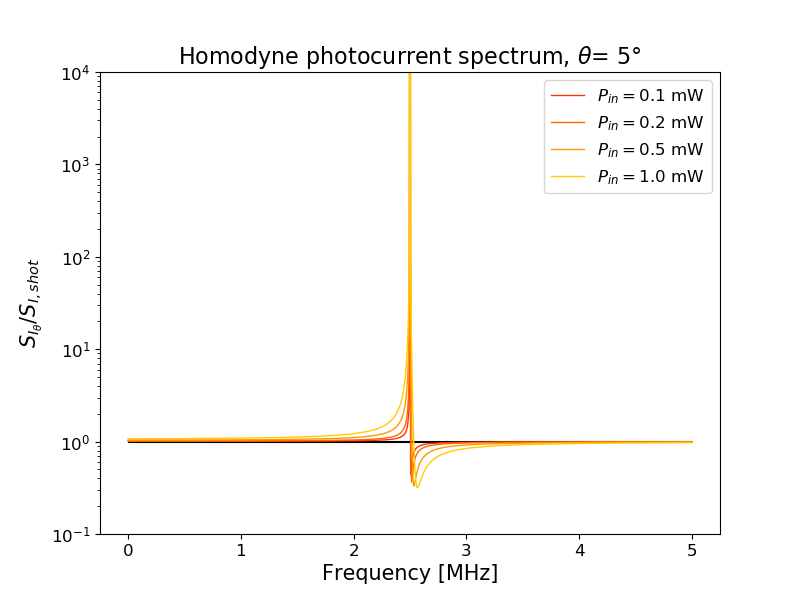

In [14]:
#Fixed quadrature angle, changing input power

P_in_sweep=[100e-6,200e-6,500e-6,1e-3]
theta=5
spec_P_sweep=np.zeros((len(P_in_sweep),len(omegas)))
k=0
for P in P_in_sweep:
    g_P_sweep=g0*np.sqrt(ic_photon_number(eta_in,kappa,P,omega_drive,2*np.pi*0))
    g_ab_sweep = Coupling(a, b, g_P_sweep * np.array([1,0,0,0]))
    sys_om_P_sweep = System([a, b], [a_in0, a_in1, a_in2, b_in0], [g_ab_sweep])
    a_out2_P_sweep = Output(sys_om_P_sweep,a_in2)
    spec_P_sweep[k,:] = 4*me.spectrum(omegas,me.HomodynMeasurement(a_out2_P_sweep,theta*np.pi/180), components=False)
    k+=1
    
plt.figure(figsize=(8,6))
cmap=plt.get_cmap('autumn')
for k in range(len(P_in_sweep)):
    color=cmap(float(k+1)/(len(P_in_sweep)+1))
    plt.semilogy(1e-6*omegas/2/np.pi, spec_P_sweep[k,:], c=color, linewidth=1, label=r'$P_{in}=$' + str(P_in_sweep[k]*1e3) + ' mW')
plt.hlines(1,1e-6*omegas[0]/2/np.pi,1e-6*omegas[len(omegas)-1]/2/np.pi,linestyles='solid')
plt.xlabel('Frequency [MHz]', fontsize=15)
plt.ylabel(r'$S_{I_\theta}/S_{I,shot}$', fontsize=15)
plt.title(r'Homodyne photocurrent spectrum, $\theta$= ' + str(theta) + '°', fontsize=16);
plt.legend(loc='upper right', fontsize=12);
plt.xticks(fontsize=12, rotation=0)
plt.yticks(fontsize=12, rotation=0)
axes=plt.gca()
axes.set_ylim([0.1,10000]);
    

In [12]:
theta=np.linspace(-90,90,201)
spec=np.zeros((len(theta),len(omegas)))
k=0
for t in theta:
    spec[k,:] = 4*me.spectrum(omegas,me.HomodynMeasurement(a_out2,t*np.pi/180), components=False)
    k+=1

<IPython.core.display.Javascript object>


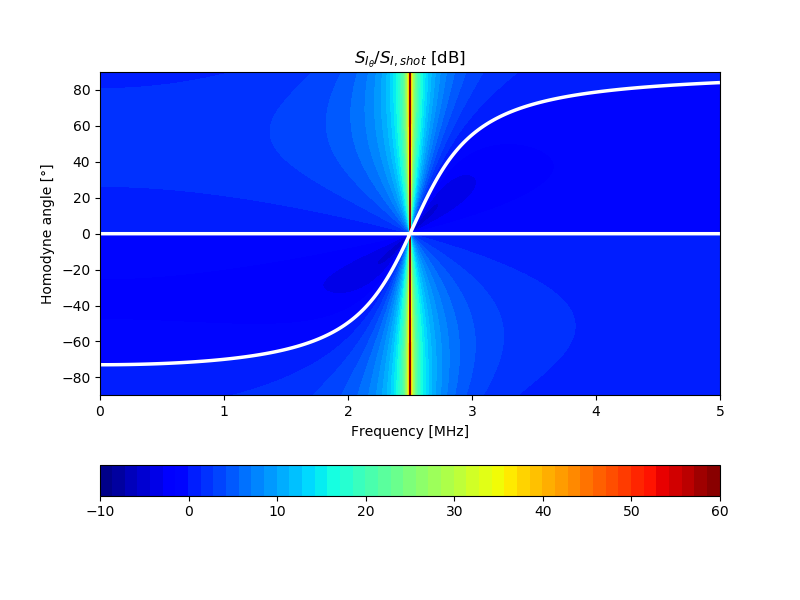

Maximal squeezing below shot noise: 5.03 dB


In [13]:
plt.figure(figsize=(8,6))
spec_min=np.amin(spec)
T,O=np.meshgrid(omegas/2/np.pi/1e6,theta)
map=plt.contourf(T,O,np.clip(10*np.log10(spec),-10,60),levels=np.linspace(-10,60,num=50),cmap=plt.get_cmap('jet'));
plt.colorbar(orientation='horizontal',ticks=np.linspace(-10,60,num=8));
plt.xlabel('Frequency [MHz]')
plt.ylabel('Homodyne angle [°]')
plt.title(r'$S_{I_\theta}/S_{I,shot}$ [dB]');
plt.contour(map,levels=[0],colors='w', linewidths=[2.5])

print(f'Maximal squeezing below shot noise: {-10*np.log10(spec_min):.2f} dB')